In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [129]:
from torch import Tensor
import torch.nn as nn 
import torch.optim as optim 
import torchmetrics
import torchvision
import torchvision.transforms as transforms
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection 
import torch.utils.data as data 
import numpy as np
import torch

In [130]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 200

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([200, 3, 32, 32])


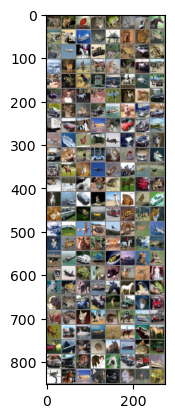

bird  frog  ship  cat   frog  cat   ship  horse deer  plane ship  frog  plane cat   frog  frog  bird  plane horse truck deer  frog  car   bird  plane deer  horse horse horse deer  horse horse dog   frog  bird  truck cat   horse ship  car   bird  dog   horse deer  plane deer  bird  car   car   deer  plane car   ship  horse car   car   truck car   dog   plane dog   car   car   plane deer  ship  bird  horse plane cat   car   bird  truck frog  deer  car   cat   bird  car   ship  truck horse bird  plane frog  truck ship  dog   cat   deer  cat   frog  frog  horse car   frog  horse ship  car   horse bird  frog  bird  car   cat   car   bird  plane truck frog  deer  cat   plane plane plane bird  bird  dog   deer  plane dog   bird  horse deer  horse horse car   frog  bird  ship  car   car   car   ship  cat   deer  ship  plane frog  cat   cat   horse bird  dog   dog   frog  deer  ship  horse horse bird  frog  dog   frog  car   car   deer  truck dog   car   deer  cat   cat   horse frog  horse ship

In [131]:

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [132]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1=nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 100, 3)
        self.bn2=nn.BatchNorm2d(100)
        self.conv3 = nn.Conv2d(100, 150, 3)
        self.bn3=nn.BatchNorm2d(150)
        self.conv4 = nn.Conv2d(150, 200, 3)
        self.bn4=nn.BatchNorm2d(200)
        self.conv5 = nn.Conv2d(200, 300, 3)
        self.bn5=nn.BatchNorm2d(300)
        self.fc1 = nn.Linear(300 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)    
    def forward(self, x):
        x = self.bn1(self.pool(torch.relu(self.conv1(x))))
        x = self.bn2(torch.relu(self.conv2(x)))
        x = self.bn3(torch.relu(self.conv3(x)))
        x = self.bn4(torch.relu(self.conv4(x)))
        x = self.bn5(torch.relu(self.conv5(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [133]:
net = Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
net.to(device)


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)


import time

start_time=time.time();
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
end_time=time.time()

print("Training time:",end_time-start_time,"seconds")

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

cuda:0
Finished Training
Training time: 251.067724943161 seconds
Accuracy of the network on the 10000 test images: 74 %
